In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# One more import after logging in

from items import Item

In [9]:
%matplotlib inline

In [10]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [11]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [17]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [18]:
train[0].features.keys()

dict_keys(['Color', 'Brand', 'Vehicle Service Type', 'Auto Part Position', 'Installation Type', 'Finish Type', 'Manufacturer', 'Item Weight', 'Package Dimensions', 'Is Discontinued By Manufacturer', 'Manufacturer Part Number', 'Best Sellers Rank', 'Date First Available', 'Material Stainless Steel', ''])

In [29]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 290573),
 ('Brand', 276016),
 ('Manufacturer', 269430),
 ('Item Weight', 261567),
 ('Best Sellers Rank', 250321),
 ('Item model number', 199717),
 ('Product Dimensions', 179881),
 ('Manufacturer Part Number', 169591),
 ('Is Discontinued By Manufacturer', 111608),
 ('Color', 105475),
 ('Country of Origin', 94960),
 ('Model', 80305),
 ('OEM Part Number', 71694),
 ('Package Dimensions', 63675),
 ('Material', 63356),
 ('Exterior', 62758),
 ('Vehicle Service Type', 61283),
 ('Item Dimensions LxWxH', 53078),
 ('Special Feature', 48563),
 ('Position', 34455),
 ('Special Features', 34332),
 ('Auto Part Position', 34060),
 ('Compatible Devices', 32080),
 ('Connectivity Technology', 26920),
 ('Style', 26233),
 ('Model Name', 25726),
 ('', 23864),
 ('Item Dimensions  LxWxH', 23107),
 ('Voltage', 21941),
 ('Exterior Finish', 20925),
 ('Fit Type', 20633),
 ('Batteries', 20393),
 ('Included Components', 18287),
 ('Screen Size', 18122),
 ('Specific Uses For Product', 17837),

In [30]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [31]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

4.75 Tons


In [32]:
average_weight = sum(weights)/len(weights)
average_weight

13.028331211483804

In [33]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [34]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [35]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

455594.02549329726

In [36]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [37]:
def get_text_length(item):
    return len(item.test_prompt())

In [38]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 4383),
 ('Power Stop', 3685),
 ('Detroit Axle', 3426),
 ('Dorman', 3412),
 ('Dell', 3146),
 ('ACDelco', 2361),
 ('Lenovo', 2337),
 ('Evan Fischer', 1822),
 ('BUYAUTOPARTS!', 1656),
 ('ASUS', 1391),
 ('Sony', 1342),
 ('Callahan BRAKE PARTS', 1284),
 ('Rareelectrical', 1275),
 ('SAMSUNG', 1263),
 ('Garage-Pro', 1190),
 ('CURT', 1136),
 ('Cardone', 1125),
 ('Spectra Premium', 1106),
 ('Auto Dynasty', 1084),
 ('Coverking', 1072),
 ('WeatherTech', 1035),
 ('TYC', 1018),
 ('A-Premium', 1015),
 ('R1 Concepts', 1009),
 ('GM', 1000),
 ('EBC Brakes', 989),
 ('ECCPP', 925),
 ('Walker', 898),
 ('DB Electrical', 890),
 ('K&N', 867),
 ('APS', 853),
 ('SCITOO', 819),
 ('AKKON', 818),
 ('Canon', 793),
 ('AM Autoparts', 789),
 ('Covercraft', 739),
 ('DNA MOTORING', 738),
 ('SPEC-D TUNING', 728),
 ('Intel', 704),
 ('Apple', 694)]

In [39]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [40]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [41]:
# Look at features in a training item
get_features(train[0])

{'weight': 8.0,
 'rank': 196918.0,
 'text_length': 744,
 'is_top_electronics_brand': 0}

In [42]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

4.75 Tons


In [43]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.13241043868978014
rank: 4.1024461225319275e-05
text_length: -0.0017105901575158624
is_top_electronics_brand: 198.87671511801213
Intercept: 165.20045082744
Mean Squared Error: 26669.242912911483
R-squared Score: 0.10805701832670112


In [44]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $184.95 Truth: $203.78 Error: $18.83 SLE: 0.01 Item: EBC Brakes GD1070 3GD Series Dimpled and...
2: Guess: $183.66 Truth: $285.75 Error: $102.09 SLE: 0.19 Item: Evan-Fischer Fuel Tank Compatible with T...
3: Guess: $220.51 Truth: $122.99 Error: $97.52 SLE: 0.34 Item: ECCPP CV Joint Half Axle Shaft Assembly ...
4: Guess: $184.37 Truth: $123.18 Error: $61.19 SLE: 0.16 Item: For 11-17 Honda Odyssey 17 Inch Painted ...
5: Guess: $164.63 Truth: $89.34 Error: $75.29 SLE: 0.37 Item: Cisco Console Cable 6 ft with USB Type A...
6: Guess: $207.68 Truth: $269.96 Error: $62.28 SLE: 0.07 Item: Max Advanced Brakes Elite XDS Front + Re...
7: Guess: $182.85 Truth: $57.98 Error: $124.87 SLE: 1.29 Item: Maxell 1 TB GENpro External Hard Drive 6...
8: Guess: $164.02 Truth: $199.00 Error: $34.98 SLE: 0.04 Item: Lumantek SDI to HDMI Converter with Disp...
9: Guess: $169.30 Truth: $489.99 Error: $320.69 SLE: 1.12 Item: THINKWARE U1000 Front and Rear 4K Dash C...
10: Guess: $168.26 Truth: $549.99 Er

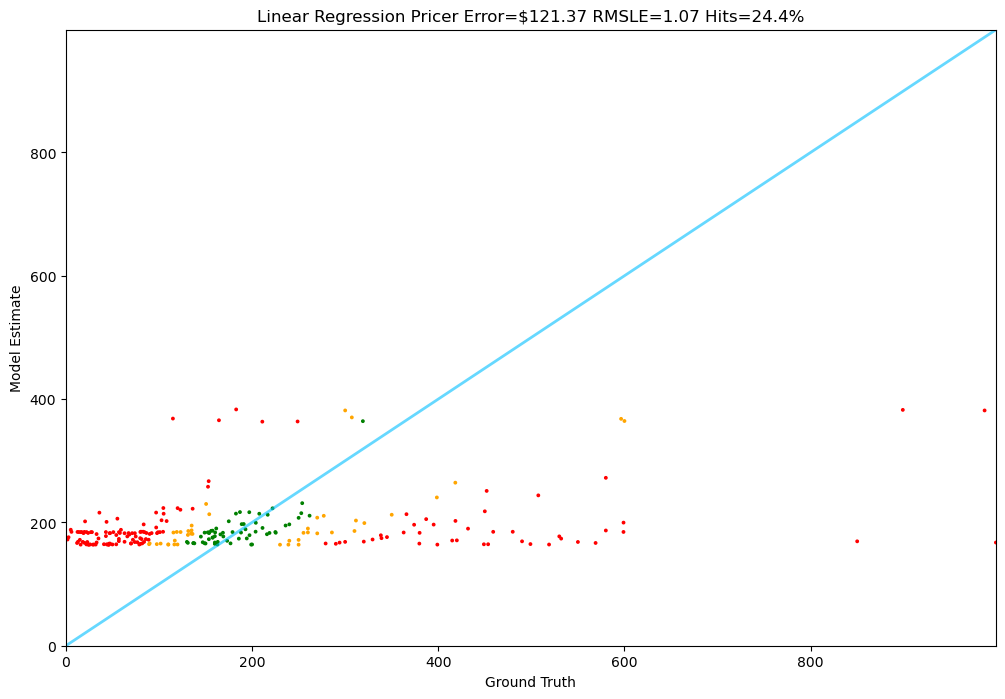

In [45]:
# test it

Tester.test(linear_regression_pricer)

In [46]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [47]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [48]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $187.17 Truth: $203.78 Error: $16.61 SLE: 0.01 Item: EBC Brakes GD1070 3GD Series Dimpled and...
2: Guess: $205.89 Truth: $285.75 Error: $79.86 SLE: 0.11 Item: Evan-Fischer Fuel Tank Compatible with T...
3: Guess: $175.53 Truth: $122.99 Error: $52.54 SLE: 0.12 Item: ECCPP CV Joint Half Axle Shaft Assembly ...
4: Guess: $225.09 Truth: $123.18 Error: $101.91 SLE: 0.36 Item: For 11-17 Honda Odyssey 17 Inch Painted ...
5: Guess: $244.94 Truth: $89.34 Error: $155.60 SLE: 1.00 Item: Cisco Console Cable 6 ft with USB Type A...
6: Guess: $219.69 Truth: $269.96 Error: $50.27 SLE: 0.04 Item: Max Advanced Brakes Elite XDS Front + Re...
7: Guess: $180.37 Truth: $57.98 Error: $122.39 SLE: 1.26 Item: Maxell 1 TB GENpro External Hard Drive 6...
8: Guess: $221.77 Truth: $199.00 Error: $22.77 SLE: 0.01 Item: Lumantek SDI to HDMI Converter with Disp...
9: Guess: $292.46 Truth: $489.99 Error: $197.53 SLE: 0.26 Item: THINKWARE U1000 Front and Rear 4K Dash C...
10: Guess: $276.35 Truth: $549.99 E

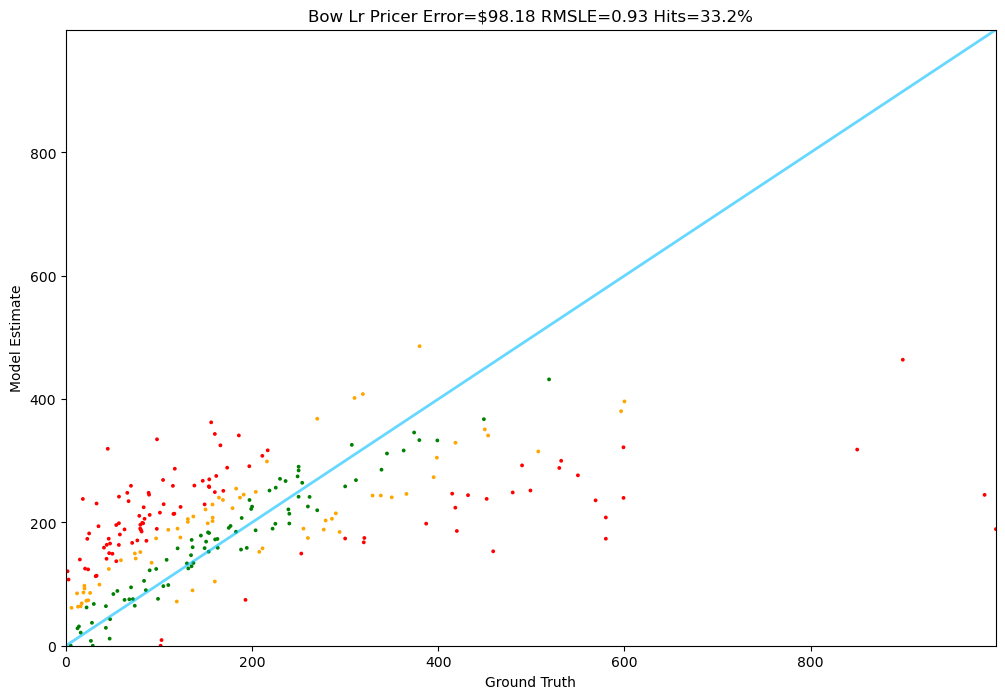

In [49]:
# test it

Tester.test(bow_lr_pricer)

In [50]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [51]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [52]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [53]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $230.53 Truth: $203.78 Error: $26.75 SLE: 0.02 Item: EBC Brakes GD1070 3GD Series Dimpled and...
2: Guess: $195.51 Truth: $285.75 Error: $90.24 SLE: 0.14 Item: Evan-Fischer Fuel Tank Compatible with T...
3: Guess: $108.56 Truth: $122.99 Error: $14.43 SLE: 0.02 Item: ECCPP CV Joint Half Axle Shaft Assembly ...
4: Guess: $211.93 Truth: $123.18 Error: $88.75 SLE: 0.29 Item: For 11-17 Honda Odyssey 17 Inch Painted ...
5: Guess: $254.46 Truth: $89.34 Error: $165.12 SLE: 1.08 Item: Cisco Console Cable 6 ft with USB Type A...
6: Guess: $200.34 Truth: $269.96 Error: $69.62 SLE: 0.09 Item: Max Advanced Brakes Elite XDS Front + Re...
7: Guess: $131.27 Truth: $57.98 Error: $73.29 SLE: 0.65 Item: Maxell 1 TB GENpro External Hard Drive 6...
8: Guess: $222.68 Truth: $199.00 Error: $23.68 SLE: 0.01 Item: Lumantek SDI to HDMI Converter with Disp...
9: Guess: $243.52 Truth: $489.99 Error: $246.47 SLE: 0.49 Item: THINKWARE U1000 Front and Rear 4K Dash C...
10: Guess: $276.78 Truth: $549.99 Err

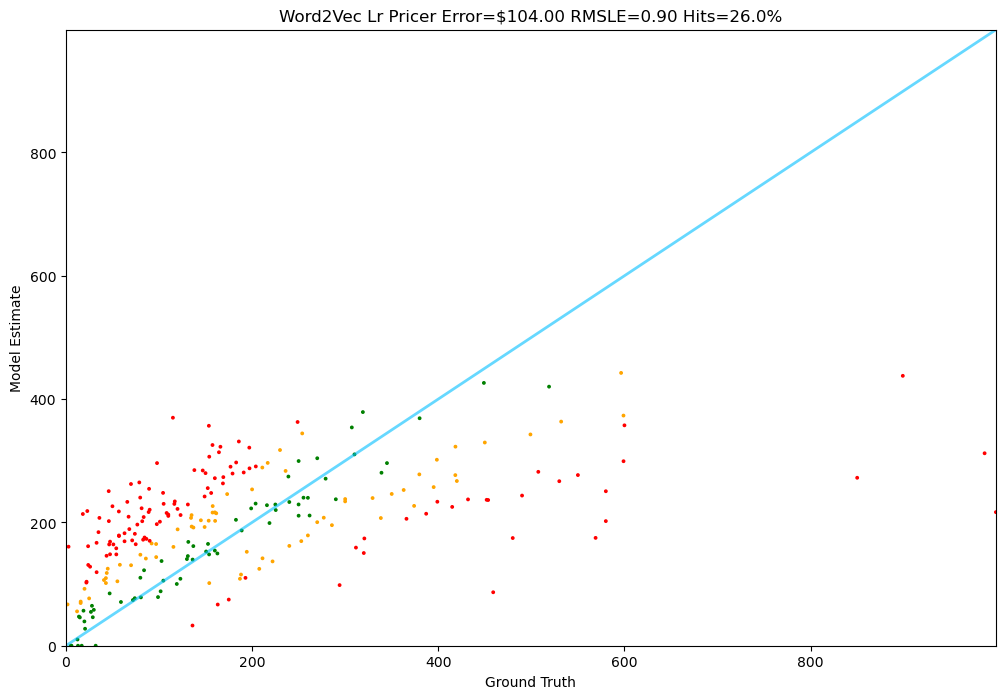

In [54]:
Tester.test(word2vec_lr_pricer)

In [55]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [56]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $185.63 Truth: $203.78 Error: $18.15 SLE: 0.01 Item: EBC Brakes GD1070 3GD Series Dimpled and...
2: Guess: $176.88 Truth: $285.75 Error: $108.87 SLE: 0.23 Item: Evan-Fischer Fuel Tank Compatible with T...
3: Guess: $100.06 Truth: $122.99 Error: $22.93 SLE: 0.04 Item: ECCPP CV Joint Half Axle Shaft Assembly ...
4: Guess: $174.38 Truth: $123.18 Error: $51.20 SLE: 0.12 Item: For 11-17 Honda Odyssey 17 Inch Painted ...
5: Guess: $207.47 Truth: $89.34 Error: $118.13 SLE: 0.70 Item: Cisco Console Cable 6 ft with USB Type A...
6: Guess: $208.01 Truth: $269.96 Error: $61.95 SLE: 0.07 Item: Max Advanced Brakes Elite XDS Front + Re...
7: Guess: $100.76 Truth: $57.98 Error: $42.78 SLE: 0.30 Item: Maxell 1 TB GENpro External Hard Drive 6...
8: Guess: $126.86 Truth: $199.00 Error: $72.14 SLE: 0.20 Item: Lumantek SDI to HDMI Converter with Disp...
9: Guess: $190.47 Truth: $489.99 Error: $299.52 SLE: 0.89 Item: THINKWARE U1000 Front and Rear 4K Dash C...
10: Guess: $203.92 Truth: $549.99 Er

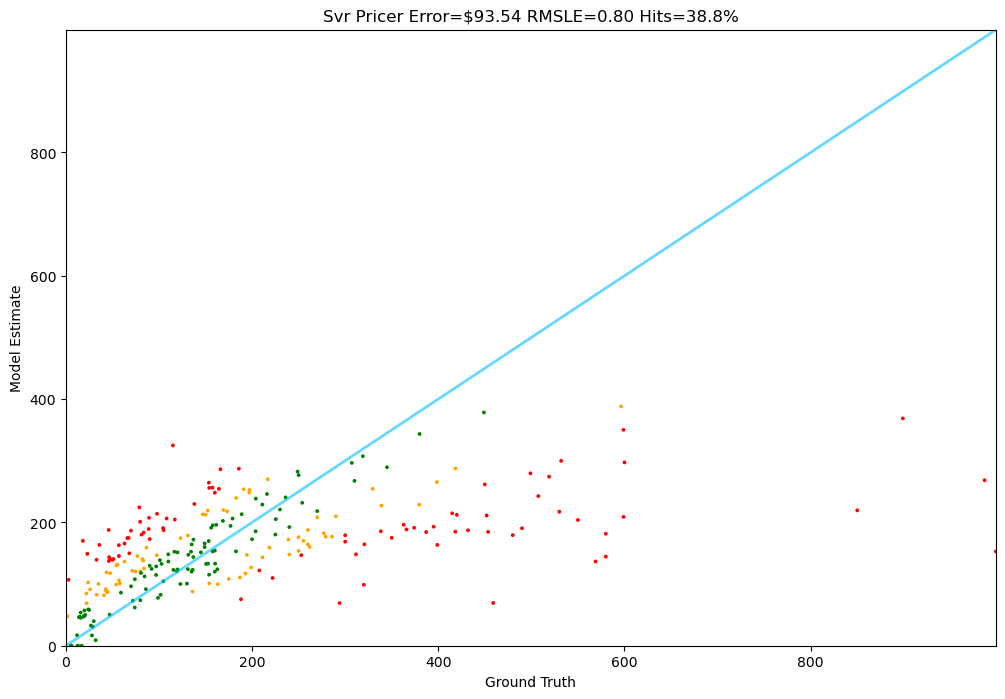

In [57]:
Tester.test(svr_pricer)

In [ ]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)